In [2]:
from pathlib import Path
import numpy as np, pandas as pd, itertools
from sklearn.base import clone
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor

#### visualize performance across different datasets

In [3]:
import matplotlib.pyplot as plt
import json

In [4]:
experiment_map = {'exp1': 'feat_2080','exp2': 'feat_3900','exp3': 'decorr_2080','exp4': 'decorr_3900',
'exp5': 'pca_global_2080','exp6': 'pca_global_3900','exp7': 'pca_per-group_2080','exp8': 'pca_per-group_3900'}

In [5]:
base_dir = Path("../results/ML/")
all_records = []

def parse_test_results(file_path, exp_name, records_list):
    if not file_path.exists():
        return
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    for dimension in ['Valence', 'Arousal']:
        metrics = data['test_metrics'][dimension]['Test']
        records_list.append({'model': experiment_map[exp_name], 'metric': f'{dimension} RMSE', 'score': metrics['RMSE']})
        records_list.append({'model': experiment_map[exp_name], 'metric': f'{dimension} R2', 'score': metrics['R2']})

for i in range(1, 9):
    exp_name = f"exp{i}"
    parse_test_results(base_dir / exp_name / "RF_Custom_Split.json", exp_name, all_records)

results_df = pd.DataFrame(all_records)
print(results_df.head(2))

       model        metric     score
0  feat_2080  Valence RMSE  0.941621
1  feat_2080    Valence R2  0.353479


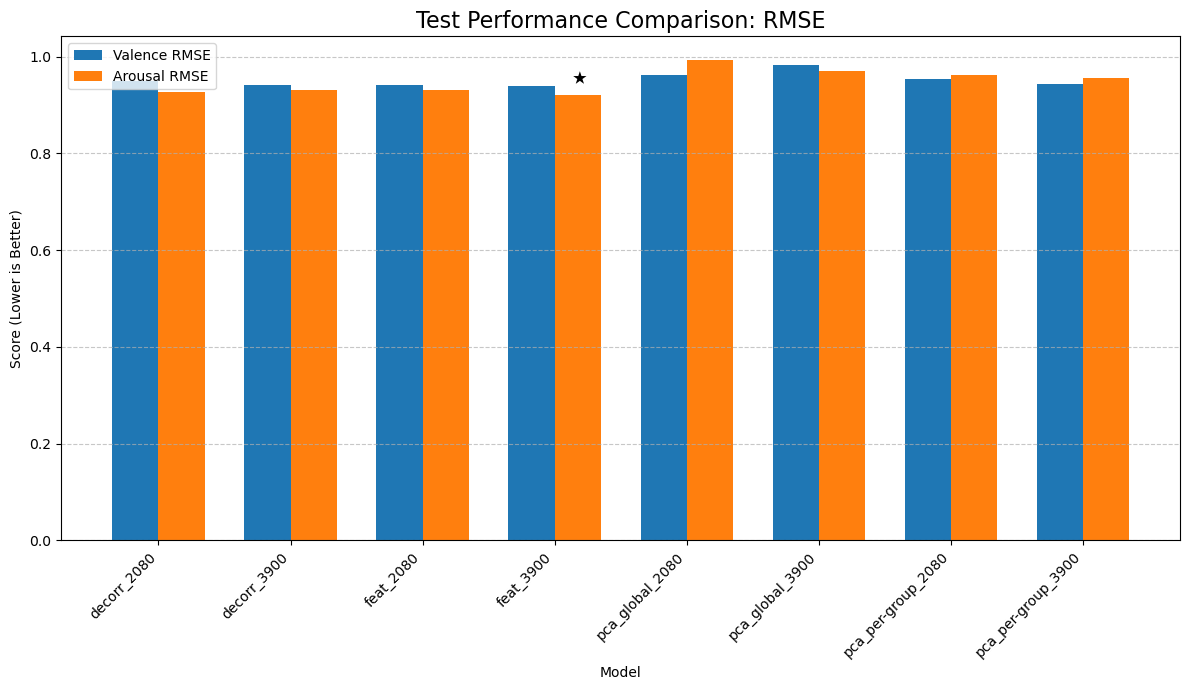

In [6]:
fig, ax = plt.subplots(figsize=(12, 7))
metric_type = 'RMSE'
# Filter data for RMSE and sort for consistent order
metric_df = results_df[results_df['metric'].str.contains(metric_type)].sort_values('model')

valence_scores = metric_df[metric_df['metric'].str.contains('Valence')]['score']
arousal_scores = metric_df[metric_df['metric'].str.contains('Arousal')]['score']
models = sorted(metric_df['model'].unique())

x = np.arange(len(models))
width = 0.35

ax.bar(x - width/2, valence_scores, width, label='Valence RMSE', color='#1f77b4')
ax.bar(x + width/2, arousal_scores, width, label='Arousal RMSE', color='#ff7f0e')

# Find and annotate the best model
if not metric_df.empty:
    best_idx = metric_df['score'].idxmin()
    best_model_info = metric_df.loc[best_idx]
    model_index = models.index(best_model_info['model'])
    is_valence_bar = 'Valence' in best_model_info['metric']
    x_pos = model_index - width/2 if is_valence_bar else model_index + width/2
    y_pos = best_model_info['score']
    ax.text(x_pos, y_pos, r"$\star$", ha='center', va='bottom', fontsize=25, color='black')

ax.set_title(f'Test Performance Comparison: {metric_type}', fontsize=16)
ax.set_ylabel('Score (Lower is Better)')
ax.set_xlabel('Model')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
fig.tight_layout()
plt.show()

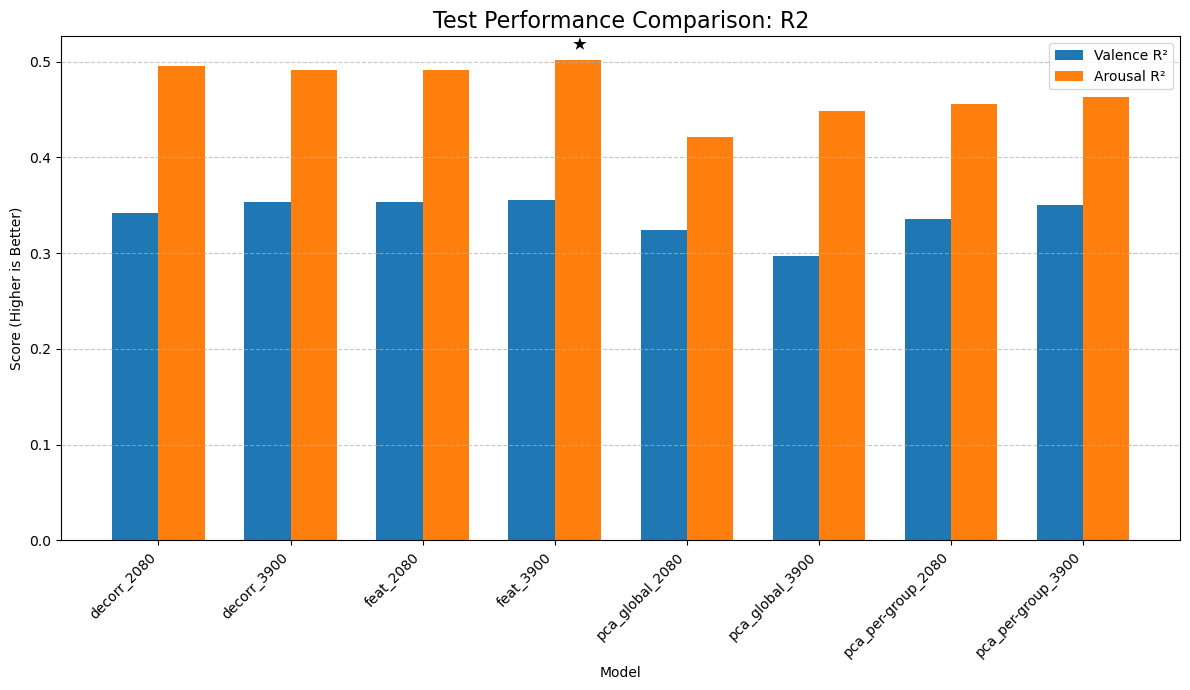

In [7]:
fig, ax = plt.subplots(figsize=(12, 7))
metric_type = 'R2'

metric_df = results_df[results_df['metric'].str.contains(metric_type)].sort_values('model')

valence_scores = metric_df[metric_df['metric'].str.contains('Valence')]['score']
arousal_scores = metric_df[metric_df['metric'].str.contains('Arousal')]['score']
models = sorted(metric_df['model'].unique())

x = np.arange(len(models))
width = 0.35

ax.bar(x - width/2, valence_scores, width, label='Valence R²', color='#1f77b4')
ax.bar(x + width/2, arousal_scores, width, label='Arousal R²', color='#ff7f0e')

if not metric_df.empty:
    best_idx = metric_df['score'].idxmax()
    best_model_info = metric_df.loc[best_idx]
    
    model_index = models.index(best_model_info['model'])
    is_valence_bar = 'Valence' in best_model_info['metric']
    x_pos = model_index - width/2 if is_valence_bar else model_index + width/2
    y_pos = best_model_info['score']
    
    ax.text(x_pos, y_pos, r"$\star$", ha='center', va='bottom', fontsize=25, color='black')

ax.set_title(f'Test Performance Comparison: {metric_type}', fontsize=16)
ax.set_ylabel('Score (Higher is Better)')
ax.set_xlabel('Model')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

fig.tight_layout()
plt.show()

### Model Selection and Hyperparameter Optimization

In [8]:
DATASETS = {
    "feat_2080": Path("../data/processed/derived/exp1_full_2080"),
    "feat_3900": Path("../data/processed/derived/exp2_full_3900"),
    "decorr_2080": Path("../data/processed/derived/exp3_decorrelated_2080"),
    "decorr_3900": Path("../data/processed/derived/exp4_decorrelated_3900"),
    "pca_global_2080": Path("../data/processed/derived/exp5_pca_global_2080"),
    "pca_global_3900": Path("../data/processed/derived/exp6_pca_global_3900"),
    "pca_per_group_2080": Path("../data/processed/derived/exp7_pca_per_group_2080"),
    "pca_per_group_3900": Path("../data/processed/derived/exp8_pca_per_group_3900")
}

In [9]:
TARGETS = ["valence", "arousal"]
ALL_RESULTS = []

In [10]:
def rmse(y, p): return float(np.sqrt(mean_squared_error(y, p)))
def r2(y, p): return float(r2_score(y, p))

In [11]:
def read_target(d: Path, target: str, split: str) -> pd.Series:
    """Read y_<target>_<split>_custom.csv and return it as a Series."""
    df = pd.read_csv(d / f"y_{target}_{split}_custom.csv", index_col=0)
    if df.shape[1] == 1:
        s = df.iloc[:, 0]
    else:
        cols = [c for c in df.columns if target in c] or list(df.columns)
        s = df[cols[0]]
    s.index = s.index.astype(int)
    s.name = target
    return s

In [12]:
def load_custom_split(base_dir: Path, target: str):
    d = base_dir / "custom_split"
    if not d.exists():
        raise FileNotFoundError(f"'custom_split' not found under: {base_dir}")
    
    X_train = pd.read_parquet(d / "X_train_scaled_custom.parquet")
    X_val   = pd.read_parquet(d / "X_val_scaled_custom.parquet")
    X_test  = pd.read_parquet(d / "X_test_scaled_custom.parquet")
    
    y_train = read_target(d, target, "train")
    y_val   = read_target(d, target, "val")
    y_test  = read_target(d, target, "test")
    
    def _align(X, y):
        common = X.index.intersection(y.index)
        return X.loc[common], y.loc[common]
    
    X_train, y_train = _align(X_train, y_train)
    X_val,   y_val   = _align(X_val,   y_val)
    X_test,  y_test  = _align(X_test,  y_test)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

### Evaluate the datasets on different models

In [13]:
# add MLP model
import tensorflow as tf
from tensorflow import keras

# Enable GPU memory growth to avoid OOM
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

2025-09-11 08:46:03.066349: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-11 08:46:03.203309: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
def build_and_train_nn(X_train, y_train, X_val, y_val, 
                       hidden=[128, 64], dropout=0.2, lr=0.001):
    model = keras.Sequential([
        keras.layers.Dense(hidden[0], activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dropout(dropout),
        *[layer for h in hidden[1:] for layer in 
          (keras.layers.Dense(h, activation='relu'), keras.layers.Dropout(dropout))],
        keras.layers.Dense(1)
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(lr), loss='mse')
    
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=500,
        batch_size=32,
        callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=0
    )
    return model

In [15]:
from sklearn.base import BaseEstimator, RegressorMixin

class KerasNN(BaseEstimator, RegressorMixin):
    def __init__(self, input_dim=None, hidden_units=[128, 64], learning_rate=0.001, 
                 epochs=60, batch_size=32, dropout=0.2):
        self.input_dim = input_dim
        self.hidden_units = hidden_units
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.dropout = dropout
        self.model = None
        
    def build_model(self, input_dim):
        layers = []
        # First layer
        layers.append(tf.keras.layers.Dense(self.hidden_units[0], activation='relu', 
                                           input_shape=(input_dim,)))
        layers.append(tf.keras.layers.Dropout(self.dropout))
        
        # Additional hidden layers
        for units in self.hidden_units[1:]:
            layers.append(tf.keras.layers.Dense(units, activation='relu'))
            layers.append(tf.keras.layers.Dropout(self.dropout))
        
        # Output layer
        layers.append(tf.keras.layers.Dense(1))
        
        model = tf.keras.Sequential(layers)
        model.compile(optimizer=tf.keras.optimizers.Adam(self.learning_rate),
                     loss='mse', metrics=['mae'])
        return model
    
    def fit(self, X, y):
        if self.input_dim is None:
            self.input_dim = X.shape[1]
        
        self.model = self.build_model(self.input_dim)
        
        # Add early stopping
        early_stop = tf.keras.callbacks.EarlyStopping(
            monitor='loss', patience=10, restore_best_weights=True
        )
        
        self.model.fit(X, y, 
                      epochs=self.epochs, 
                      batch_size=self.batch_size, 
                      callbacks=[early_stop],
                      verbose=0)
        return self
    
    def predict(self, X):
        return self.model.predict(X, verbose=0).flatten()

In [ ]:
out_dir = Path("../results/final_test_metrics")
out_dir.mkdir(parents=True, exist_ok=True)

BEST_MODELS = {}
ALL_RESULTS = []

for ds_name, base_dir in DATASETS.items():
    print(f"\n====================  {ds_name}  ====================")

    # load
    Xtr, Xva, Xte, ytr_v, yva_v, yte_v = load_custom_split(base_dir, "valence")
    _,   _,   _,   ytr_a, yva_a, yte_a = load_custom_split(base_dir, "arousal")

    # fp32 + concat train+val
    Xtr = Xtr.astype(np.float32); Xva = Xva.astype(np.float32); Xte = Xte.astype(np.float32)
    Xtv = pd.concat([Xtr, Xva], axis=0)
    ytv_v = pd.concat([ytr_v, yva_v], axis=0)
    ytv_a = pd.concat([ytr_a, yva_a], axis=0)

    rows = []
    best_score = -np.inf         # <- highest sum of R²
    best_model_name = None
    best_model_obj = None
    best_params_global = None

    cands = {
        "RF":   RandomForestRegressor(random_state=42, n_jobs=-1),
        "GBR":  GradientBoostingRegressor(random_state=42),
        "Ridge": Ridge(),
        "SVR":  SVR(kernel="rbf"),
        "KNN":  KNeighborsRegressor(),
        "PLS":  PLSRegression(),  # n_components tuned below
        "NN":   KerasNN()
    }

    max_pls = int(min(20, Xtr.shape[1], len(Xtr)-1))
    grids = {
        "RF":   {"n_estimators":[300,600], "max_features":["sqrt"], "min_samples_leaf":[1,2]},
        "GBR":  {"n_estimators":[300,600], "max_depth":[3], "learning_rate":[0.05,0.1]},
        "Ridge":{"alpha": np.logspace(-3,3,7)},
        "SVR":  {"C": np.logspace(-2,2,5), "gamma": ["scale","auto"]},
        "KNN":  {"n_neighbors":[3,5,11], "weights":["uniform","distance"]},
        "PLS":  {"n_components":[n for n in range(2, min(13, max_pls+1), 2)]},
        "NN":   {"hidden_units": [[32,16], [32,16,8], [32], [32,32,16],[32,32],[64],[64,64],[64,32],[64,32,16]],
                 "dropout": [0.2,0.3], "learning_rate": [0.01,0.001], "batch_size": [16,32,64]}
    }

    for name, base in cands.items():
        grid = grids.get(name, {})
        combos = list(ParameterGrid(grid)) if grid else [None]

        # pick params by valence validation RMSE (unchanged for selection)
        best_val = np.inf
        best_params = None
        for params in combos:
            m = clone(base)
            if params: m.set_params(**params)
            m.fit(Xtr, ytr_v)
            v_rmse = rmse(yva_v, m.predict(Xva))
            if v_rmse < best_val:
                best_val, best_params = v_rmse, params

        # refit on train+val for BOTH targets with the chosen params
        final_m_v = clone(base); final_m_a = clone(base)
        if best_params:
            final_m_v.set_params(**best_params)
            final_m_a.set_params(**best_params)
        final_m_v.fit(Xtv, ytv_v)
        final_m_a.fit(Xtv, ytv_a)

        # test metrics
        pred_v = final_m_v.predict(Xte); pred_a = final_m_a.predict(Xte)
        v_test_rmse = rmse(yte_v, pred_v); v_test_r2 = r2(yte_v, pred_v)
        a_test_rmse = rmse(yte_a, pred_a); a_test_r2 = r2(yte_a, pred_a)
        sum_r2 = v_test_r2 + a_test_r2

        rows.append({
            "dataset": ds_name,
            "model": name,
            "val_rmse": best_val,
            "valence_test_rmse": v_test_rmse,
            "valence_test_r2": v_test_r2,
            "arousal_test_rmse": a_test_rmse,
            "arousal_test_r2": a_test_r2,
            "sum_r2": sum_r2,
            "params": best_params
        })

        # choose BEST by highest (R²_v + R²_a)
        if sum_r2 > best_score:
            best_score = sum_r2
            best_model_name = name
            best_model_obj = (final_m_v, final_m_a, best_params)
            best_params_global = best_params

        # save one JSON per model for plotting later
        payload = {
            "rmse_v": v_test_rmse, "rmse_a": a_test_rmse,
            "r2_v": v_test_r2, "r2_a": a_test_r2
        }
        (out_dir / f"{ds_name}_{name}_Custom_split.json").write_text(json.dumps(payload, indent=2))

    # summary table
    df_bakeoff = pd.DataFrame(rows).sort_values(["sum_r2","valence_test_r2","arousal_test_r2"], ascending=[False,False,False]).reset_index(drop=True)
    print(df_bakeoff.to_string(index=False))
    ALL_RESULTS.append(df_bakeoff)

    # record best
    BEST_MODELS[ds_name] = {
        "name": best_model_name,
        "sum_r2": best_score,
        "best_params": best_params_global,
        "models": best_model_obj,
        "Xtv": Xtv, "ytv_v": ytv_v, "ytv_a": ytv_a,
        "Xte": Xte, "yte_v": yte_v, "yte_a": yte_a
    }

    # also save a BEST summary json
    best_row = df_bakeoff.iloc[0]
    best_payload = {
        "best_model": best_row["model"],
        "sum_r2": float(best_row["sum_r2"]),
        "rmse_v": float(best_row["valence_test_rmse"]),
        "rmse_a": float(best_row["arousal_test_rmse"]),
        "r2_v":   float(best_row["valence_test_r2"]),
        "r2_a":   float(best_row["arousal_test_r2"]),
        "params": best_row["params"] if pd.notnull(best_row["params"]) else None
    }
    (out_dir / f"{ds_name}_BEST_by_sumR2.json").write_text(json.dumps(best_payload, indent=2))


====================  feat_2080  ====================


### Summaries

In [12]:
summary = pd.concat(ALL_RESULTS, ignore_index=True)
print("\n=== Overall summary (sorted by dataset, then valence test_rmse) ===")
print(summary.sort_values(["dataset","valence_test_rmse","val_rmse"])[:20].to_string(index=False))


=== Overall summary (sorted by dataset, then valence test_rmse) ===
    dataset model  val_rmse  valence_test_rmse  valence_test_r2  arousal_test_rmse  arousal_test_r2                                                                                  params
decorr_2080    RF  0.821576           0.946786         0.346366           0.925563         0.497115                    {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 600}
decorr_2080   GBR  0.827726           0.961171         0.326353           0.914142         0.509450                            {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}
decorr_2080 Ridge  0.889090           0.966743         0.318520           0.935043         0.486761                                                                       {'alpha': 1000.0}
decorr_2080   KNN  0.926727           0.967460         0.317509           0.972704         0.444584                                              {'n_neighbors': 11, 'weights': 'di

In [1]:
winners = summary.sort_values(["dataset","valence_test_rmse","val_rmse"]).groupby("dataset").head(1)
print("\n=== Best models per dataset (optimized on valence, showing both targets) ===")
print(winners[["dataset","model","valence_test_rmse","valence_test_r2",
               "arousal_test_rmse","arousal_test_r2","params"]].to_string(index=False))

NameError: name 'summary' is not defined

### Part 3: LLD Analysis

In [16]:
def read_X(base_dir: Path):
    d = base_dir / "custom_split"
    Xtr = pd.read_parquet(d / "X_train_scaled_custom.parquet")
    Xva = pd.read_parquet(d / "X_val_scaled_custom.parquet")
    Xte = pd.read_parquet(d / "X_test_scaled_custom.parquet")
    cols = Xtr.columns.union(Xva.columns).union(Xte.columns)
    return cols

pc_pat = re.compile(r"_PC\d+$", re.I)

In [17]:
def parse_base_desc(col: str):
    """Return (base, desc) from 'base_desc'. Return (None,None) for non-LLD (e.g. PCs)."""
    if pc_pat.search(col):
        return (None, None)
    if "_" not in col:
        return (None, None)
    base, desc = col.rsplit("_", 1)
    return base, desc

desc_presence = {}
desc_column_counts = {}
base_desc_presence = {}
dataset_desc_lists = {}

In [18]:
for name, base_dir in DATASETS.items():
    try:
        cols = read_X(base_dir)
    except Exception:
        continue
    
    descs_here = set()
    for c in cols:
        base, desc = parse_base_desc(c)
        if base is None:
            continue
        descs_here.add(desc)
        desc_presence.setdefault(desc, set()).add(name)
        desc_column_counts[desc] = desc_column_counts.get(desc, 0) + 1
        base_desc_presence.setdefault((base, desc), set()).add(name)
    dataset_desc_lists[name] = descs_here

In [19]:
top_desc = sorted(desc_presence.items(), key=lambda kv: (-len(kv[1]), -desc_column_counts.get(kv[0],0)))
print("\nTop LLD descriptors by presence across datasets:")
for desc, ds in top_desc[:20]:
    print(f"  {desc:<12} in {len(ds)} datasets (columns total = {desc_column_counts[desc]})  → {sorted(ds)}")


Top LLD descriptors by presence across datasets:
  q25          in 4 datasets (columns total = 947)  → ['decorr_2080', 'decorr_3900', 'feat_2080', 'feat_3900']
  min          in 4 datasets (columns total = 930)  → ['decorr_2080', 'decorr_3900', 'feat_2080', 'feat_3900']
  q75          in 3 datasets (columns total = 596)  → ['decorr_3900', 'feat_2080', 'feat_3900']
  std          in 3 datasets (columns total = 188)  → ['decorr_2080', 'decorr_3900', 'feat_2080']
  mean         in 3 datasets (columns total = 172)  → ['decorr_2080', 'decorr_3900', 'feat_2080']
  median       in 1 datasets (columns total = 128)  → ['feat_3900']
  mad          in 1 datasets (columns total = 112)  → ['feat_3900']
  max          in 1 datasets (columns total = 109)  → ['decorr_2080']
  iqr          in 1 datasets (columns total = 84)  → ['feat_3900']
  skew         in 1 datasets (columns total = 53)  → ['decorr_2080']
  kurtosis     in 1 datasets (columns total = 50)  → ['decorr_2080']
  variation    in 1 datas

In [20]:
non_pca = [k for k in DATASETS if "pca_" not in k]
consensus = [d for d, ds in desc_presence.items() if all(k in ds for k in non_pca)]
print(f"\nDescriptors present in ALL non-PCA datasets: {consensus or '— none —'}")


Descriptors present in ALL non-PCA datasets: ['q25', 'min']


### Reduced LLD Design Testing

In [21]:
K = 6
prominent_desc = [d for d,_ in top_desc[:K]]

RF_BEST = {
    "decorr_2080": {"n_estimators": 600, "max_features": "sqrt", "min_samples_leaf": 2, "random_state": 42, "n_jobs": -1},
    "pca_global_2080": {"n_estimators": 600, "max_features": "sqrt", "min_samples_leaf": 1, "random_state": 42, "n_jobs": -1},
    "pca_global_3900": {"n_estimators": 300, "max_features": "sqrt", "min_samples_leaf": 1, "random_state": 42, "n_jobs": -1},
    "pca_per_group_2080": {"n_estimators": 300, "max_features": "sqrt", "min_samples_leaf": 1, "random_state": 42, "n_jobs": -1},
    "pca_per_group_3900": {"n_estimators": 300, "max_features": "sqrt", "min_samples_leaf": 1, "random_state": 42, "n_jobs": -1},
}
RIDGE_ALPHA = 1000.0

In [22]:
rows = []
REDUCED_BEST_MODELS = {}
for ds_name, base_dir in DATASETS.items():
    try:
        Xtr, Xva, Xte, ytr_v, yva_v, yte_v = load_custom_split(base_dir, "valence")
        _, _, _, ytr_a, yva_a, yte_a = load_custom_split(base_dir, "arousal")
    except Exception:
        continue
    
    # Build reduced column set for non-PCA designs
    keep = [c for c in Xtr.columns if parse_base_desc(c)[1] in prominent_desc]
    if len(keep) == 0:
        print(f"[{ds_name}] no LLD columns after filtering — skipping (likely PCA dataset).")
        continue
    
    Xtr_f = Xtr[keep]
    Xva_f = Xva[keep]
    Xte_f = Xte[keep]
    
    # Combined data
    Xtv_f = pd.concat([Xtr_f, Xva_f])
    ytv_v = pd.concat([ytr_v, yva_v])
    ytv_a = pd.concat([ytr_a, yva_a])
    
    # Ridge
    ridge_v = Ridge(alpha=RIDGE_ALPHA)
    ridge_a = Ridge(alpha=RIDGE_ALPHA)
    ridge_v.fit(Xtv_f, ytv_v)
    ridge_a.fit(Xtv_f, ytv_a)
    
    pred_ridge_v = ridge_v.predict(Xte_f)
    pred_ridge_a = ridge_a.predict(Xte_f)
    ridge_v_rmse = rmse(yte_v, pred_ridge_v)
    ridge_v_r2 = r2(yte_v, pred_ridge_v)
    ridge_a_rmse = rmse(yte_a, pred_ridge_a)
    ridge_a_r2 = r2(yte_a, pred_ridge_a)
    
    # RF
    rf_params = RF_BEST.get(ds_name, {"n_estimators":600, "max_features":"sqrt",
                                      "min_samples_leaf":1, "random_state":42, "n_jobs":-1})
    rf_v = RandomForestRegressor(**rf_params)
    rf_a = RandomForestRegressor(**rf_params)
    rf_v.fit(Xtv_f, ytv_v)
    rf_a.fit(Xtv_f, ytv_a)
    
    pred_rf_v = rf_v.predict(Xte_f)
    pred_rf_a = rf_a.predict(Xte_f)
    rf_v_rmse = rmse(yte_v, pred_rf_v)
    rf_v_r2 = r2(yte_v, pred_rf_v)
    rf_a_rmse = rmse(yte_a, pred_rf_a)
    rf_a_r2 = r2(yte_a, pred_rf_a)
    
    rows.append({
        "dataset": ds_name, 
        "n_cols": len(keep),
        "Ridge_v_rmse": ridge_v_rmse, 
        "Ridge_v_r2": ridge_v_r2,
        "Ridge_a_rmse": ridge_a_rmse, 
        "Ridge_a_r2": ridge_a_r2,
        "RF_v_rmse": rf_v_rmse, 
        "RF_v_r2": rf_v_r2,
        "RF_a_rmse": rf_a_rmse,
        "RF_a_r2": rf_a_r2,
    })
    
    # Store best reduced model
    if rf_v_rmse < ridge_v_rmse:
        REDUCED_BEST_MODELS[ds_name] = {
            'name': 'RF_reduced',
            'models': (rf_v, rf_a),
            'Xte': Xte_f,
            'yte_v': yte_v,
            'yte_a': yte_a
        }
    else:
        REDUCED_BEST_MODELS[ds_name] = {
            'name': 'Ridge_reduced',
            'models': (ridge_v, ridge_a),
            'Xte': Xte_f,
            'yte_v': yte_v,
            'yte_a': yte_a
        }

[pca_global_2080] no LLD columns after filtering — skipping (likely PCA dataset).
[pca_global_3900] no LLD columns after filtering — skipping (likely PCA dataset).
[pca_per_group_2080] no LLD columns after filtering — skipping (likely PCA dataset).
[pca_per_group_3900] no LLD columns after filtering — skipping (likely PCA dataset).


In [23]:
df_reduced = pd.DataFrame(rows).sort_values("RF_v_rmse")
print("\n=== Test performance on reduced (prominent LLD) designs ===")
print(df_reduced.to_string(index=False))


=== Test performance on reduced (prominent LLD) designs ===
    dataset  n_cols  Ridge_v_rmse  Ridge_v_r2  Ridge_a_rmse  Ridge_a_r2  RF_v_rmse  RF_v_r2  RF_a_rmse  RF_a_r2
decorr_2080     621      0.967164    0.317926      0.961797    0.456970   0.944432 0.349612   0.931247 0.490919
  feat_2080     780      0.949220    0.343001      0.981842    0.434100   0.951210 0.340244   0.923720 0.499116
decorr_3900     780      0.949220    0.343001      0.981842    0.434100   0.951210 0.340244   0.923720 0.499116
  feat_3900     780      0.936644    0.360295      0.964719    0.453666   0.952746 0.338111   0.927364 0.495156


### Part 5: V-A Space Analysis

In [24]:
def create_va_bins(y_valence, y_arousal, n_bins_v=4, n_bins_a=4):
    """Create bins in V-A space based on actual data range.
    Returns bin edges and bin assignments for each sample"""
    # Get actual ranges
    v_min, v_max = y_valence.min(), y_valence.max()
    a_min, a_max = y_arousal.min(), y_arousal.max()
    
    # Create bin edges
    v_edges = np.linspace(v_min, v_max, n_bins_v + 1)
    a_edges = np.linspace(a_min, a_max, n_bins_a + 1)
    
    # Assign bins (digitize returns 1-based indices, we want 0-based)
    v_bins = np.digitize(y_valence, v_edges) - 1
    a_bins = np.digitize(y_arousal, a_edges) - 1
    
    # Handle edge cases (max values)
    v_bins = np.clip(v_bins, 0, n_bins_v - 1)
    a_bins = np.clip(a_bins, 0, n_bins_a - 1)
    
    return v_edges, a_edges, v_bins, a_bins

In [25]:
def evaluate_va_space(model_v, model_a, X_test, y_test_v, y_test_a, 
                     n_bins_v=4, n_bins_a=4, model_name="Model", dataset_name="Dataset"):
    """Evaluate model performance in different V-A space regions"""
    # Get predictions
    pred_v = model_v.predict(X_test)
    pred_a = model_a.predict(X_test)
    
    # Create bins
    v_edges, a_edges, v_bins, a_bins = create_va_bins(y_test_v, y_test_a, n_bins_v, n_bins_a)
    
    # Analyze performance in each quadrant
    results = []
    
    for v_bin in range(n_bins_v):
        for a_bin in range(n_bins_a):
            mask = (v_bins == v_bin) & (a_bins == a_bin)
            n_samples = mask.sum()
            
            if n_samples > 0:
                # Calculate metrics for this region
                rmse_v = rmse(y_test_v[mask], pred_v[mask])
                rmse_a = rmse(y_test_a[mask], pred_a[mask])
                
                # Handle R2 for small samples
                if n_samples > 1:
                    r2_v = r2(y_test_v[mask], pred_v[mask])
                    r2_a = r2(y_test_a[mask], pred_a[mask])
                else:
                    r2_v = np.nan
                    r2_a = np.nan
                
                results.append({
                    'dataset': dataset_name,
                    'model': model_name,
                    'v_bin': v_bin,
                    'a_bin': a_bin,
                    'v_range': f"[{v_edges[v_bin]:.2f}, {v_edges[v_bin+1]:.2f}]",
                    'a_range': f"[{a_edges[a_bin]:.2f}, {a_edges[a_bin+1]:.2f}]",
                    'n_samples': n_samples,
                    'v_rmse': rmse_v,
                    'a_rmse': rmse_a,
                    'v_r2': r2_v,
                    'a_r2': r2_a,
                    'combined_rmse': (rmse_v + rmse_a) / 2  # Simple average for ranking
                })
    
    return pd.DataFrame(results)

In [26]:
# Evaluate best models in V-A space
all_va_results = []

print("\n=== Evaluating best full models in V-A space ===")
for ds_name, model_info in BEST_MODELS.items():
    if model_info['models'] is None:
        continue
    
    model_v, model_a, _ = model_info['models']
    df_va = evaluate_va_space(
        model_v, model_a,
        model_info['Xte'],
        model_info['yte_v'],
        model_info['yte_a'],
        n_bins_v=3,  # Using 3x3 grid for better sample sizes
        n_bins_a=3,
        model_name=model_info['name'],
        dataset_name=ds_name
    )
    all_va_results.append(df_va)


=== Evaluating best full models in V-A space ===


In [27]:
print("\n=== Evaluating best reduced models in V-A space ===")
for ds_name, model_info in REDUCED_BEST_MODELS.items():
    model_v, model_a = model_info['models']
    df_va = evaluate_va_space(
        model_v, model_a,
        model_info['Xte'],
        model_info['yte_v'],
        model_info['yte_a'],
        n_bins_v=3,
        n_bins_a=3,
        model_name=model_info['name'],
        dataset_name=ds_name + "_reduced"
    )
    all_va_results.append(df_va)


=== Evaluating best reduced models in V-A space ===



=== Top 10 best-performing V-A regions (by combined RMSE) ===
            dataset         model      v_range      a_range  n_samples   v_rmse   a_rmse  combined_rmse
 pca_per_group_2080            RF [4.03, 5.97] [3.90, 5.70]         73 0.635759 0.585560       0.610659
    pca_global_2080            RF [4.03, 5.97] [3.90, 5.70]         73 0.629231 0.617826       0.623529
  feat_2080_reduced Ridge_reduced [4.03, 5.97] [3.90, 5.70]         73 0.645795 0.612367       0.629081
decorr_3900_reduced Ridge_reduced [4.03, 5.97] [3.90, 5.70]         73 0.645795 0.612367       0.629081
          feat_2080         Ridge [4.03, 5.97] [3.90, 5.70]         73 0.645795 0.612367       0.629081
        decorr_3900         Ridge [4.03, 5.97] [3.90, 5.70]         73 0.645795 0.612367       0.629081
  feat_3900_reduced Ridge_reduced [4.03, 5.97] [3.90, 5.70]         73 0.653100 0.606379       0.629739
 pca_per_group_3900            RF [4.03, 5.97] [3.90, 5.70]         73 0.661582 0.605793       0.633688
 

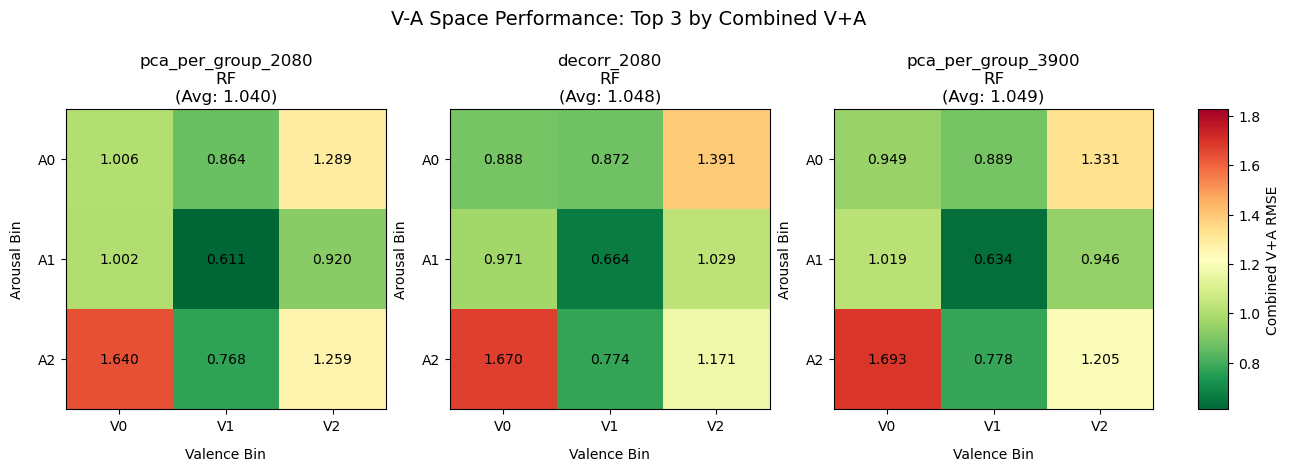

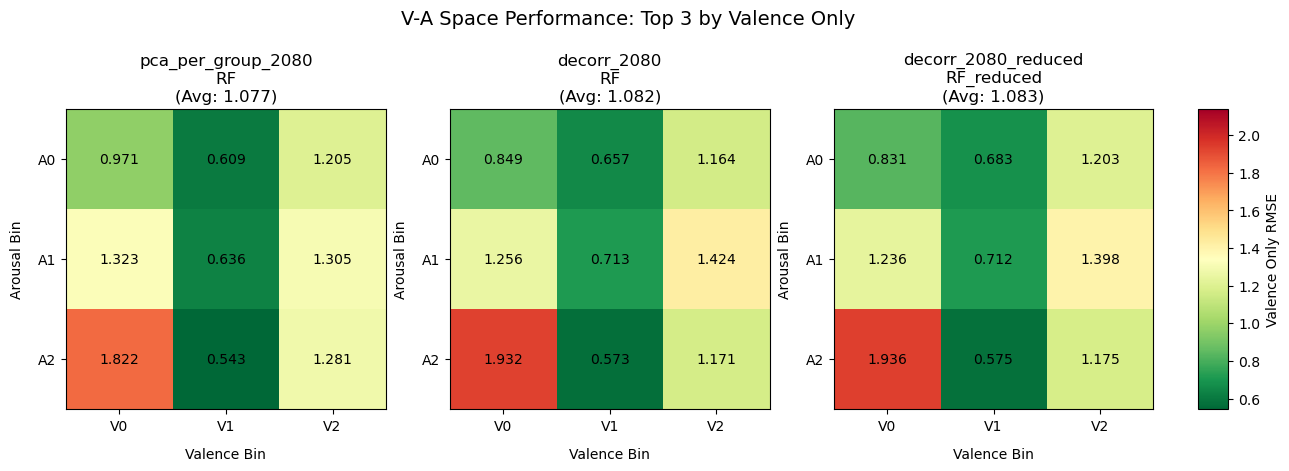

In [29]:
# Combine and analyze results
if all_va_results:
    va_df = pd.concat(all_va_results, ignore_index=True)
    
    # Show best performing regions
    print("\n=== Top 10 best-performing V-A regions (by combined RMSE) ===")
    best_regions = va_df.nsmallest(10, 'combined_rmse')
    print(best_regions[['dataset', 'model', 'v_range', 'a_range', 
                        'n_samples', 'v_rmse', 'a_rmse', 'combined_rmse']].to_string(index=False))
    
    # Find top 3 by combined RMSE
    model_dataset_avg = va_df.groupby(['dataset', 'model']).agg({
        'combined_rmse': 'mean',
        'v_rmse': 'mean',
        'a_rmse': 'mean'
    }).reset_index()
    
    top_3_combined = model_dataset_avg.nsmallest(3, 'combined_rmse')
    top_3_valence = model_dataset_avg.nsmallest(3, 'v_rmse')
    
    print("\n=== Top 3 Model-Dataset Combinations (Combined RMSE) ===")
    print(top_3_combined[['dataset', 'model', 'combined_rmse', 'v_rmse', 'a_rmse']].to_string(index=False))
    
    print("\n=== Top 3 Model-Dataset Combinations (Valence RMSE) ===")
    print(top_3_valence[['dataset', 'model', 'v_rmse', 'a_rmse', 'combined_rmse']].to_string(index=False))
    
    # Add spacing before plots
    print("\n" + "="*60 + "\n")
    
    # Create two sets of heatmaps
    for metric_name, top_3, metric_col in [
        ("Combined V+A", top_3_combined, 'combined_rmse'),
        ("Valence Only", top_3_valence, 'v_rmse')
    ]:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        vmin = va_df[metric_col].min()
        vmax = va_df[metric_col].max()
        
        for idx, (_, row) in enumerate(top_3.iterrows()):
            dataset = row['dataset']
            model = row['model']
            
            # Filter data for this specific combination
            combo_data = va_df[(va_df['dataset'] == dataset) & (va_df['model'] == model)]
            
            # Create pivot table for heatmap
            heatmap_data = combo_data.pivot_table(
                index='a_bin', columns='v_bin', values=metric_col
            )
            
            # Plot heatmap
            ax = axes[idx]
            im = ax.imshow(heatmap_data.values, cmap='RdYlGn_r', aspect='auto', 
                          vmin=vmin, vmax=vmax)
            
            # Labels and title
            ax.set_xlabel('Valence Bin', labelpad=10)
            ax.set_ylabel('Arousal Bin', labelpad=10)
            ax.set_title(f'{dataset}\n{model}\n(Avg: {row[metric_col]:.3f})')
            
            # Add text annotations
            for i in range(heatmap_data.shape[0]):
                for j in range(heatmap_data.shape[1]):
                    if not np.isnan(heatmap_data.iloc[i, j]):
                        text = ax.text(j, i, f'{heatmap_data.iloc[i, j]:.3f}',
                                     ha="center", va="center", color="black", fontsize=10)
            
            # Set ticks
            ax.set_xticks(range(heatmap_data.shape[1]))
            ax.set_yticks(range(heatmap_data.shape[0]))
            ax.set_xticklabels([f'V{i}' for i in range(heatmap_data.shape[1])])
            ax.set_yticklabels([f'A{i}' for i in range(heatmap_data.shape[0])])
        
        # Add colorbar to the right of all subplots
        fig.subplots_adjust(right=0.85, top=0.75, bottom=0.15)  # Much lower top to make room
        cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.6])
        fig.colorbar(im, cax=cbar_ax, label=f'{metric_name} RMSE')
        
        # Main title with more space
        fig.suptitle(f'V-A Space Performance: Top 3 by {metric_name}', fontsize=14, y=0.95)
        plt.show()

In [85]:
def visualize_bin_accuracy(pred_v, pred_a, true_v, true_a, 
                           v_edges, a_edges, title="Model", ax=None):
    n_v, n_a = len(v_edges) - 1, len(a_edges) - 1

    # 1) Consistent binning using full edges
    tv = np.clip(np.digitize(true_v, v_edges) - 1, 0, n_v - 1)
    ta = np.clip(np.digitize(true_a, a_edges) - 1, 0, n_a - 1)
    pv = np.clip(np.digitize(pred_v, v_edges) - 1, 0, n_v - 1)
    pa = np.clip(np.digitize(pred_a, a_edges) - 1, 0, n_a - 1)

    # 2) Vectorized counts
    match = (pv == tv) & (pa == ta)
    idx_v = np.arange(n_v + 1)
    idx_a = np.arange(n_a + 1)

    grid_total, _, _ = np.histogram2d(tv, ta, bins=[idx_v, idx_a])
    grid_correct, _, _ = np.histogram2d(tv[match], ta[match], bins=[idx_v, idx_a])

    with np.errstate(invalid='ignore', divide='ignore'):
        grid_pct = np.where(grid_total > 0, 100 * grid_correct / grid_total, np.nan)

    # 3) Plot (flip once so low valence is at bottom)
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    data = grid_pct[::-1, :]  # flip rows for display
    # build "c/t" annotations and flip to match
    annot = np.empty_like(grid_total, dtype=object)
    for i in range(n_v):
        for j in range(n_a):
            annot[i, j] = f"{int(grid_correct[i, j])}/{int(grid_total[i, j])}" if grid_total[i, j] > 0 else ""
    annot = annot[::-1, :]

    sns.heatmap(
        data, annot=annot, fmt='', cmap='RdYlGn',
        vmin=0, vmax=100, cbar_kws={'label': 'Accuracy %'},
        ax=ax, mask=np.isnan(data)
    )

    # 4) Labels/ticks
    v_labels = [f"{v_edges[i]:.1f}-{v_edges[i+1]:.1f}" for i in range(n_v)]
    a_labels = [f"{a_edges[i]:.1f}-{a_edges[i+1]:.1f}" for i in range(n_a)]

    ax.set_xticks(np.arange(n_a) + 0.5)
    ax.set_yticks(np.arange(n_v) + 0.5)
    ax.set_xticklabels(a_labels)
    ax.set_yticklabels(v_labels[::-1])  # because we flipped rows

    ax.set_title(title)
    ax.set_xlabel('Arousal')
    ax.set_ylabel('Valence')

    # 5) Accuracies
    v_acc = (pv == tv).mean() * 100
    a_acc = (pa == ta).mean() * 100
    both_acc = match.mean() * 100
    print(f"Accuracies: V={v_acc:.1f}%, A={a_acc:.1f}%, Both={both_acc:.1f}%")

    return {
        'v_acc': v_acc, 'a_acc': a_acc, 'both_acc': both_acc,
        'grid_correct': grid_correct, 'grid_total': grid_total
    }

Accuracies: V=57.2%, A=59.5%, Both=34.9%
Accuracies: V=57.2%, A=59.5%, Both=34.9%


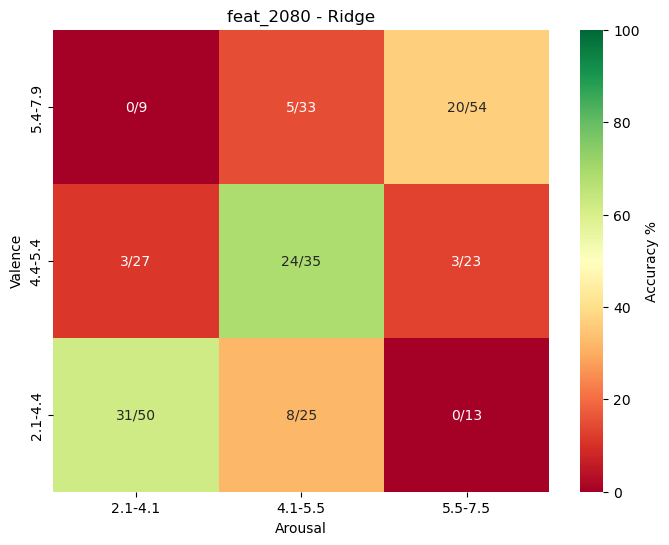

In [86]:
# Example usage - pick any dataset you have
dataset_name = 'feat_2080'  # or any dataset from BEST_MODELS

if dataset_name in BEST_MODELS:
    model_info = BEST_MODELS[dataset_name]
    model_v, model_a, _ = model_info['models']
    
    # Get predictions
    pred_v = model_v.predict(model_info['Xte'])
    pred_a = model_a.predict(model_info['Xte'])
    
    # Visualize
    results = visualize_bin_accuracy(
        pred_v, pred_a, 
        model_info['yte_v'], model_info['yte_a'],
        v_edges_3x3, a_edges_3x3, 
        f"{dataset_name} - {model_info['name']}"
    )
    print(f"Accuracies: V={results['v_acc']:.1f}%, A={results['a_acc']:.1f}%, Both={results['both_acc']:.1f}%")

# For deep learning models:
# pred_v = deep_model_v.predict(X_test).flatten()
# pred_a = deep_model_a.predict(X_test).flatten()

In [ ]:
# Save classification results
with open(save_dir / 'bin_classification_results.json', 'w') as f:
    json.dump(classification_results, f, indent=2)

### save best models, results and configs

In [35]:
import pickle
import json

# Save top 10 models by combined RMSE
print("\n=== Top 10 Models by Combined V+A RMSE ===")
summary['combined_rmse'] = (summary['valence_test_rmse'] + summary['arousal_test_rmse']) / 2
top_10 = summary.nsmallest(10, 'combined_rmse')

for idx, row in top_10.iterrows():
    print(f"\n{idx+1}. {row['dataset']} - {row['model']}")
    print(f"   Valence RMSE: {row['valence_test_rmse']:.4f}, R²: {row['valence_test_r2']:.4f}")
    print(f"   Arousal RMSE: {row['arousal_test_rmse']:.4f}, R²: {row['arousal_test_r2']:.4f}")
    print(f"   Combined RMSE: {row['combined_rmse']:.4f}")
    print(f"   Parameters: {row['params']}")


=== Top 10 Models by Combined V+A RMSE ===

2. feat_2080 - RF
   Valence RMSE: 0.9499, R²: 0.3421
   Arousal RMSE: 0.9220, R²: 0.5009
   Combined RMSE: 0.9360
   Parameters: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300}

23. decorr_3900 - RF
   Valence RMSE: 0.9499, R²: 0.3421
   Arousal RMSE: 0.9220, R²: 0.5009
   Combined RMSE: 0.9360
   Parameters: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300}

15. decorr_2080 - RF
   Valence RMSE: 0.9468, R²: 0.3464
   Arousal RMSE: 0.9256, R²: 0.4971
   Combined RMSE: 0.9362
   Parameters: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 600}

9. feat_3900 - RF
   Valence RMSE: 0.9455, R²: 0.3481
   Arousal RMSE: 0.9277, R²: 0.4948
   Combined RMSE: 0.9366
   Parameters: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300}

16. decorr_2080 - GBR
   Valence RMSE: 0.9612, R²: 0.3264
   Arousal RMSE: 0.9141, R²: 0.5094
   Combined RMSE: 0.9377
   Parameters: {'learning_rate

In [ ]:
# Save these top 4 models
save_dir = Path("../results/best_models/")
save_dir.mkdir(parents=True, exist_ok=True)

top_10_info = []
for _, row in top_10.iterrows():
    ds_name = row['dataset']
    model_name = row['model']
    
    # Get the model from BEST_MODELS
    if ds_name in BEST_MODELS and BEST_MODELS[ds_name]['name'] == model_name:
        model_v, model_a, params = BEST_MODELS[ds_name]['models']
        
        # Save models
        with open(save_dir / f"top10_{ds_name}_{model_name}_valence.pkl", 'wb') as f:
            pickle.dump(model_v, f)
        with open(save_dir / f"top10_{ds_name}_{model_name}_arousal.pkl", 'wb') as f:
            pickle.dump(model_a, f)
    
    top_10_info.append({
        'rank': len(top_10_info) + 1,
        'dataset': ds_name,
        'model': model_name,
        'valence_rmse': float(row['valence_test_rmse']),
        'valence_r2': float(row['valence_test_r2']),
        'arousal_rmse': float(row['arousal_test_rmse']),
        'arousal_r2': float(row['arousal_test_r2']),
        'combined_rmse': float(row['combined_rmse']),
        'parameters': str(row['params'])
    })

In [ ]:
with open(save_dir / 'top_10_models.json', 'w') as f:
    json.dump(top_10_info, f, indent=2)

print(f"\nTop 10 models saved to {save_dir}/top_10_models.json")